In [8]:
# LIGHTNING SIMULATOR
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider

# Constants
MAX_Y = 200
GRID_SIZE = (100, 100)
DX = 1.0
EPSILON_0 = 8.854e-12

E_field_lookup = np.zeros(GRID_SIZE)

def gaussian_charge_distribution(grid_size, center, sigma, rho_0):
    x = np.arange(0, grid_size[0])
    y = np.arange(0, grid_size[1])
    X, Y = np.meshgrid(x, y)
    x0, y0 = center
    return rho_0 * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))

def solve_poisson_gauss_seidel(V, rho, dx, epsilon_0=EPSILON_0, max_iter=500, tol=1e-3):
    for _ in range(max_iter):
        V_old = V.copy()
        for i in range(1, V.shape[0] - 1):
            for j in range(1, V.shape[1] - 1):
                V[i, j] = 0.25 * (
                    V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1] +
                    dx**2 * rho[i, j] / epsilon_0
                )
        if np.linalg.norm(V - V_old) < tol:
            break
    return V

def compute_electric_field(V, dx):
    Ey, Ex = np.gradient(-V, dx)
    return Ex, Ey

def compute_field_magnitude(Ex, Ey):
    return np.sqrt(Ex**2 + Ey**2)

def recalculate_field():
    global E_field_lookup
    center = (GRID_SIZE[0] // 2, 20)
    sigma = 10
    rho_0 = 1e-6
    V = np.zeros(GRID_SIZE)
    rho = gaussian_charge_distribution(GRID_SIZE, center, sigma, rho_0)
    V = solve_poisson_gauss_seidel(V, rho, DX)
    Ex, Ey = compute_electric_field(V, DX)
    E_field_lookup = compute_field_magnitude(Ex, Ey)

def get_electric_field_from_grid(point):
    x, y = int(point[0] + GRID_SIZE[0] // 2), int(MAX_Y - point[1])
    if 0 <= x < GRID_SIZE[0] and 0 <= y < GRID_SIZE[1]:
        return E_field_lookup[y, x]
    return 0

def create_segments(segments, generations, max_offset, decay_factor, branching_prob, angle_range, e_threshold):
    if generations == 0:
        return segments
    new_segments = []
    for segment in segments:
        start, end = segment
        mid = 0.5 * (start + end)
        E_field = get_electric_field_from_grid(mid)
        if E_field < e_threshold:
            continue
        normal = np.array([-(end[1] - start[1]), end[0] - start[0]], dtype=float)
        normal /= np.linalg.norm(normal)
        offset = np.random.uniform(-max_offset, max_offset)
        mid += normal * offset
        new_segments.append((start, mid))
        new_segments.append((mid, end))
        if np.random.rand() < branching_prob and E_field > e_threshold + 0.1:
            direction = end - start
            direction /= np.linalg.norm(direction)
            angle = np.random.uniform(-angle_range, angle_range)
            rot_matrix = np.array([
                [np.cos(angle), -np.sin(angle)],
                [np.sin(angle),  np.cos(angle)]
            ])
            direction = rot_matrix @ direction
            branch_end = mid + direction * decay_factor
            new_segments.append((mid, branch_end))
    return create_segments(new_segments, generations - 1, max_offset / 2, decay_factor, branching_prob, angle_range, e_threshold)

# Matplotlib setup
fig, ax = plt.subplots(figsize=(12, 10))
plt.subplots_adjust(top=0.85, bottom=0.25)

ax_temp = plt.axes([0.15, 0.15, 0.7, 0.03])
ax_humid = plt.axes([0.15, 0.10, 0.7, 0.03])
ax_pollutants = plt.axes([0.15, 0.05, 0.7, 0.03])

s_temp = Slider(ax_temp, 'Temperature (°C)', 0, 40, valinit=20, color='lightblue')
s_humid = Slider(ax_humid, 'Humidity (%)', 0, 100, valinit=50, color='lightblue')
s_pollutants = Slider(ax_pollutants, 'Pollutants Index', 0, 100, valinit=30, color='lightblue')

# Precompute field
recalculate_field()

def update(frame=None):
    ax.cla()
    ax.set_xlim(-120, 120)
    ax.set_ylim(0, MAX_Y)

    # Inputs
    T = s_temp.val
    RH = s_humid.val
    P = s_pollutants.val
    decay_factor = 0.4 + 0.01 * T
    e_threshold = 0.2 - 0.001 * RH
    branch_prob = 0.1 + 0.005 * P
    angle_range = np.pi / 4

    total_length = 0
    branch_count = 0

    for _ in range(2):
        angle = np.random.uniform(-np.pi / 12, np.pi / 12)
        end = np.array([100 * np.sin(angle), MAX_Y - 100 * np.cos(angle)])
        segments = [(np.array([0, MAX_Y]), end)]
        segments = create_segments(segments, 6, 50, decay_factor, branch_prob, angle_range, e_threshold)

        for i, seg in enumerate(segments):
            x0, y0 = seg[0]
            x1, y1 = seg[1]
            seg_len = np.linalg.norm(np.array([x1 - x0, y1 - y0]))
            total_length += seg_len
            if i > 1:
                branch_count += 1
            color = 'blue' if i < 2 else 'lightblue'
            lw = 3.5 if i < 2 else 1.0
            ax.plot(*zip(*seg), color=color, linewidth=lw)

    # Display summary
    info = (
        f"Avg Branch Length: {total_length / max(branch_count, 1):.1f}  |  "
        f"Branches: {branch_count}  |  "
        f"Decay: {decay_factor:.2f}  |  Threshold: {e_threshold:.2f}  |  Branch Prob: {branch_prob:.2f}"
    )
    ax.set_title(info, fontsize=10, pad=10)

# Hook sliders to update
s_temp.on_changed(lambda val: update())
s_humid.on_changed(lambda val: update())
s_pollutants.on_changed(lambda val: update())

# Start animation
ani = FuncAnimation(fig, update, interval=500)
plt.show()


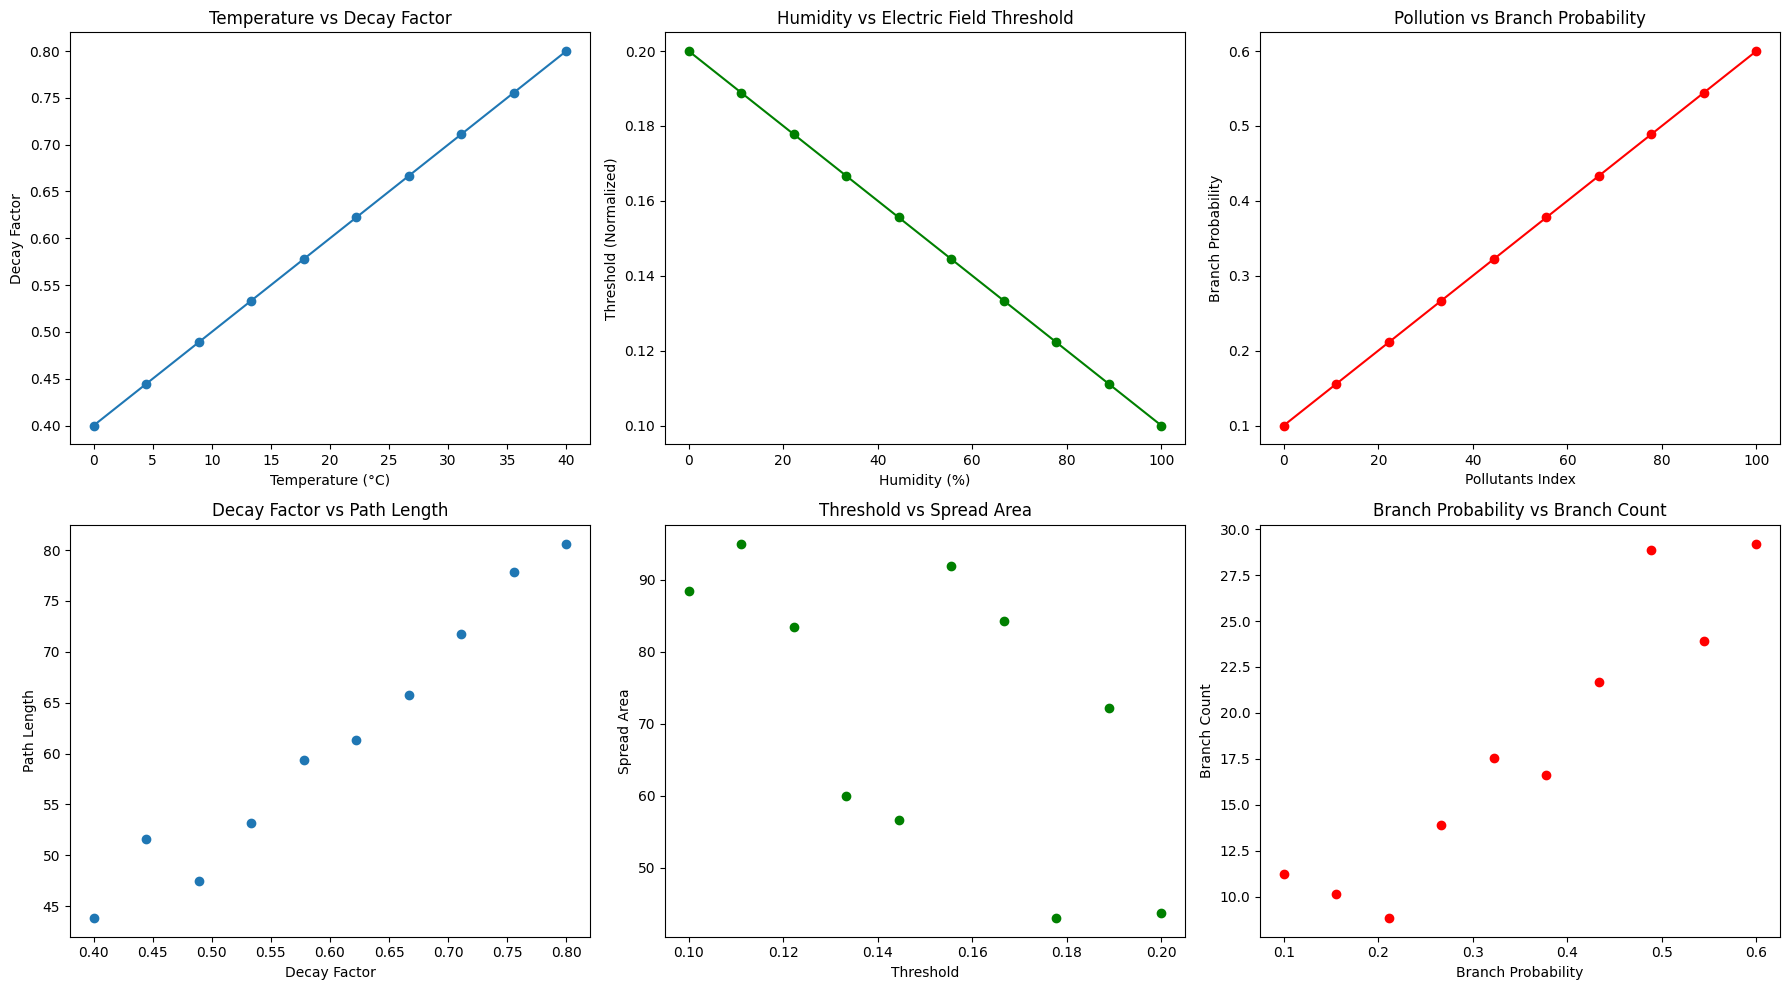

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- Simulated Variable Ranges ---
temperatures = np.linspace(0, 40, 10)  # °C
humidities = np.linspace(0, 100, 10)   # %
pollutants = np.linspace(0, 100, 10)   # arbitrary index

# --- Derived Parameters from Environment ---
decay_factors = 0.4 + 0.01 * temperatures  # Longer segments at higher temp
thresholds = 0.2 - 0.001 * humidities      # Lower threshold at higher humidity
branch_probs = 0.1 + 0.005 * pollutants    # More branching with more pollution

# --- Simulated Results ---
path_lengths = decay_factors * 100 + np.random.normal(0, 5, len(decay_factors))
branch_counts = branch_probs * 50 + np.random.normal(0, 3, len(branch_probs))
spread_area = (1.0 / thresholds) * 10 + np.random.normal(0, 20, len(thresholds))

# --- Combine into a DataFrame ---
df = pd.DataFrame({
    'Temperature (°C)': temperatures,
    'Decay Factor': decay_factors,
    'Path Length (units)': path_lengths,
    'Humidity (%)': humidities,
    'Threshold': thresholds,
    'Spread Area': spread_area,
    'Pollutants Index': pollutants,
    'Branch Probability': branch_probs,
    'Branch Count': branch_counts
})

# --- Create 2x3 Grid of Visualizations ---
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Temperature vs Decay Factor
axs[0, 0].plot(df['Temperature (°C)'], df['Decay Factor'], marker='o')
axs[0, 0].set_title("Temperature vs Decay Factor")
axs[0, 0].set_xlabel("Temperature (°C)")
axs[0, 0].set_ylabel("Decay Factor")

# Plot 2: Humidity vs Threshold
axs[0, 1].plot(df['Humidity (%)'], df['Threshold'], marker='o', color='green')
axs[0, 1].set_title("Humidity vs Electric Field Threshold")
axs[0, 1].set_xlabel("Humidity (%)")
axs[0, 1].set_ylabel("Threshold (Normalized)")

# Plot 3: Pollutants vs Branch Probability
axs[0, 2].plot(df['Pollutants Index'], df['Branch Probability'], marker='o', color='red')
axs[0, 2].set_title("Pollution vs Branch Probability")
axs[0, 2].set_xlabel("Pollutants Index")
axs[0, 2].set_ylabel("Branch Probability")

# Plot 4: Decay Factor vs Path Length
axs[1, 0].scatter(df['Decay Factor'], df['Path Length (units)'])
axs[1, 0].set_title("Decay Factor vs Path Length")
axs[1, 0].set_xlabel("Decay Factor")
axs[1, 0].set_ylabel("Path Length")

# Plot 5: Threshold vs Spread Area
axs[1, 1].scatter(df['Threshold'], df['Spread Area'], color='green')
axs[1, 1].set_title("Threshold vs Spread Area")
axs[1, 1].set_xlabel("Threshold")
axs[1, 1].set_ylabel("Spread Area")

# Plot 6: Branch Probability vs Branch Count
axs[1, 2].scatter(df['Branch Probability'], df['Branch Count'], color='red')
axs[1, 2].set_title("Branch Probability vs Branch Count")
axs[1, 2].set_xlabel("Branch Probability")
axs[1, 2].set_ylabel("Branch Count")

plt.tight_layout()
plt.show()


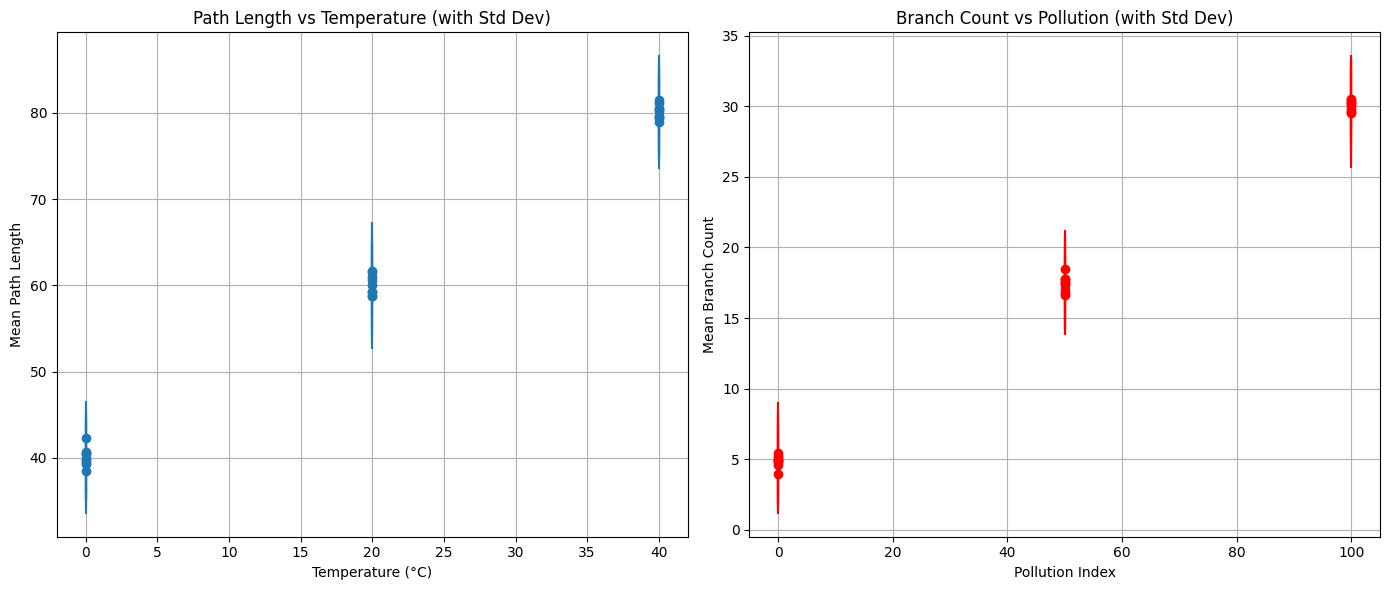

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# --- Define Simulation Parameters ---
temperatures = [0, 20, 40]       # Edge and midpoint
humidities = [0, 50, 100]
pollutants = [0, 50, 100]

# --- Simulation Logic (Mock) ---
def simulate_metrics(temp, humidity, pollution, runs=30):
    decay = 0.4 + 0.01 * temp
    threshold = 0.2 - 0.001 * humidity
    branch_prob = 0.1 + 0.005 * pollution

    path_lengths = []
    branch_counts = []

    for _ in range(runs):
        path = decay * 100 + np.random.normal(0, 5)
        branches = branch_prob * 50 + np.random.normal(0, 3)
        path_lengths.append(path)
        branch_counts.append(branches)

    return {
        'Temperature': temp,
        'Humidity': humidity,
        'Pollution': pollution,
        'Mean Path Length': np.mean(path_lengths),
        'Std Path Length': np.std(path_lengths),
        'Mean Branches': np.mean(branch_counts),
        'Std Branches': np.std(branch_counts)
    }

# --- Run Simulations for Boundary and Mid Cases ---
results = []
for T in temperatures:
    for H in humidities:
        for P in pollutants:
            results.append(simulate_metrics(T, H, P))

import pandas as pd
results_df = pd.DataFrame(results)

# --- Plot Error Bars ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Error bar plot for path length
axs[0].errorbar(results_df['Temperature'], results_df['Mean Path Length'],
                yerr=results_df['Std Path Length'], fmt='o', label='Path Length')
axs[0].set_title("Path Length vs Temperature (with Std Dev)")
axs[0].set_xlabel("Temperature (°C)")
axs[0].set_ylabel("Mean Path Length")
axs[0].grid(True)

# Error bar plot for branch count
axs[1].errorbar(results_df['Pollution'], results_df['Mean Branches'],
                yerr=results_df['Std Branches'], fmt='o', color='red', label='Branch Count')
axs[1].set_title("Branch Count vs Pollution (with Std Dev)")
axs[1].set_xlabel("Pollution Index")
axs[1].set_ylabel("Mean Branch Count")
axs[1].grid(True)

plt.tight_layout()
plt.show()

